# Aнализ Данных Сервиса Аренды Самокатов GoFast

## Задачи анализа 
- Исследовательский анализ данных о выборке пользователей из нескольких городов, а также об их поездках.

- Проверка гипотез:
 - Разница времени аренды между пользователями с подпиской и без,
 - Расстояние, проезжаемое пользователями с подпиской, не превышает оптимальное с точки зрения износа самоката значение
 - Разнице помесячной выручки между пользователями с подпиской и без.
 
- Рекомендации по охвату пользователей промо-акцией.
- Оценка конверсии push-уведомлений.
 




## Исследуемые данные
Предоставлены 3 csv файла:

1) `users_go.csv` - пользователи
- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

2) `rides_go.csv` - поездки
- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

3) `subscriptions_go.csv` - подписки
- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

Импортируем библиотеки

In [1]:
!pip install matplotlib
import pandas as pd
from math import ceil, sqrt, factorial
import numpy as np
from scipy import stats as st
from scipy.stats import poisson, binom, norm
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка и ознакомление с данными

In [2]:
users_data = pd.read_csv('/datasets/users_go.csv')
rides_data = pd.read_csv('/datasets/rides_go.csv')
subscriptions_data = pd.read_csv('/datasets/subscriptions_go.csv')

print('users_data')
display(users_data.head())
users_data.info()

print('rides_data')
display(rides_data.head())
rides_data.info()

print('subscriptions_data')
display(subscriptions_data.head())
subscriptions_data.info()

users_data


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
rides_data


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
subscriptions_data


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Таким образом, у нас имеются 3 датафрейма:
- первый содержит данные о каждом уникальном пользователе
- второй содержит данные о каждой совершенной в сервисе поездке
- третий - данные о тарификации поездки без подписки и с ней

Пропуски в данных отсутствуют, необходимо в рамках предобработки данных изменить соответствующие типы данных и проверить данные на предмет дубликатов.

#### Шаг 2. Предобработка данных

**Изменение типа данных**

In [3]:
rides_data['date'] = pd.to_datetime(rides_data['date'], format='%Y-%m-%d')
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


**Создание столбца с номером месяца**

In [4]:
rides_data['month'] = rides_data['date'].dt.month

rides_data['year'] = rides_data['date'].dt.year
year = int(rides_data['year'].unique())
print(f'Данные представлены за {year} год.')

rides_data.head()

Данные представлены за 2021 год.


,user_id,distance,duration,date,month,year
0,1,4409.919140,25.599769,2021-01-01,1,2021
1,1,2617.592153,15.816871,2021-01-18,1,2021
2,1,754.159807,6.232113,2021-04-20,4,2021
3,1,2694.783254,18.511000,2021-08-11,8,2021
4,1,4028.687306,26.265803,2021-08-28,8,2021


**Поиск пропусков**

In [5]:
df_list = [users_data, rides_data, subscriptions_data]
count = 0
for df in df_list:
    print(df.isna().sum())
    print()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
year        0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64



**Поиск дубликатов**

In [6]:
df_list = [users_data, rides_data, subscriptions_data]
count = 0
for df in df_list:
    print(df.duplicated().sum())
    print()

31

0

0



In [7]:
duplicates = users_data.loc[users_data.duplicated()]
duplicates

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


**Обработка дубликатов**

In [8]:
users_data = users_data.drop_duplicates()
users_data.duplicated().sum()

0

Сделали предобработку данных:
- убедились, что пропусков точно нет
- изменили тип данных у столбца с датой
- добавили столбцы с информацией о месяце каждой поездки и годе - данные предоставлены за 21 год
- избавились от 31 дубликата в данных о пользователях

## Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:
3.1 частота встречаемости городов;
3.2 соотношение пользователей с подпиской и без подписки;
3.3 возраст пользователей;
3.4 расстояние, которое пользователь преодолел за одну поездку;
3.5 продолжительность поездок.

**Частота встречаемости городов**

In [9]:
town_pivot = users_data['city'].value_counts()
town_pivot

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

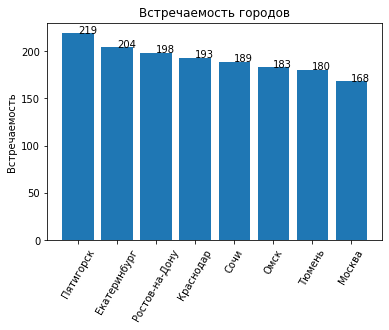

In [10]:
fig, ax = plt.subplots()

ax.set_ylabel('Встречаемость')
ax.set_title('Встречаемость городов')

towns = ax.bar(town_pivot.index, town_pivot)
plt.xticks(rotation= 60)

for elem in towns:
   height = elem.get_height()
   ax.annotate('{}'.format(height),
      xy=(elem.get_x() + elem.get_width() / 2, height))
plt.show()

**Соотношение пользователей с подпиской и без подписки**

In [11]:
sub_to_nosub = users_data.query('subscription_type == "ultra"')['subscription_type'].count() \
/ users_data.query('subscription_type == "free"')['subscription_type'].count()
print('Соотношение пользователей с подпиской к пользователем без:', round(sub_to_nosub,2))

sub_to_all = users_data.query('subscription_type == "ultra"')['subscription_type'].count() \
/ users_data['subscription_type'].count()
print('Соотношение пользователей с подпиской к общему числу пользователей:', round(sub_to_all, 2))

nosub_to_all = users_data.query('subscription_type == "free"')['subscription_type'].count() \
/ users_data['subscription_type'].count()
print('Соотношение пользователей без подписки к общему числу пользователей:', round(nosub_to_all, 2))

Соотношение пользователей с подпиской к пользователем без: 0.84
Соотношение пользователей с подпиской к общему числу пользователей: 0.46
Соотношение пользователей без подписки к общему числу пользователей: 0.54


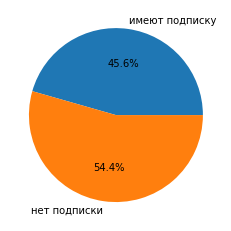

In [12]:
fig, ax = plt.subplots()
sizes = [sub_to_all, nosub_to_all]
labels = 'имеют подписку', 'нет подписки'
ax.pie(sizes, labels= labels, autopct='%1.1f%%');

Примерно равное количество пользователей с подпиской и без, однако пользователей без подписки больше - 54% против 45%.

**Возраст пользователей**

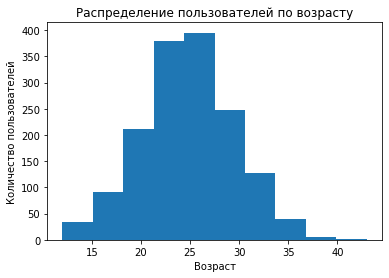

In [13]:
users_data['age'].plot(kind= 'hist')
plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей');

Средний возраст пользователей около 25 лет - около 800 человек из выборки, младше 15 лет и старше 35 встречаются единицы.

**Расстояние, которое пользователь преодолел за одну поездку**

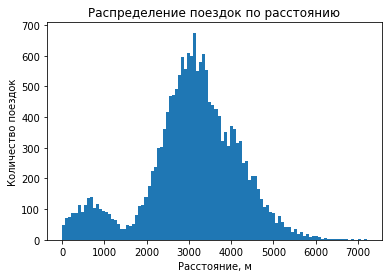

In [14]:
rides_data['distance'].plot(kind= 'hist', bins= 100);
plt.title('Распределение поездок по расстоянию')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок');

Судя по гистограмме все поездки можно разделить на 2 типа - короткие(600м в среднем) и длинные (3,5км в среднем).

**Продолжительность поездок**

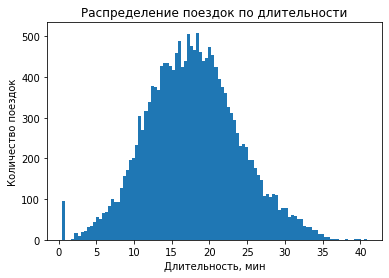

In [15]:
rides_data['duration'].plot(kind= 'hist', bins= 100);
plt.title('Распределение поездок по длительности')
plt.xlabel('Длительность, мин')
plt.ylabel('Количество поездок');

Исходя из распределения дальности поездки ожидалось аналогичное распределение
у длительности поездки, однако мы видим нормальное распределение с одним пиком на уровне около 20 минут. Единственным логичным 
объяснением на данный момент кажется разница средней скорости между пользователей с короткими и длинными поездками.

Также на себя обращает внимание 100 поездок с длительностью около 0 - аренда была завершена практически сразу после начала.
Будем помнить про эту группу и уберем ее, если она будет влиять на выводы.

#### Шаг 4. Объединение данных

**Объединение данных в один датафрейм**

In [16]:
data = (rides_data
.merge(users_data, on= 'user_id', how= 'left')
.merge(subscriptions_data, on= 'subscription_type', how= 'left')
)
data

,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,2021,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,2021,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,2021,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,2021,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,2021,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,2021,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,2021,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,2021,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,2021,Альберт,25,Краснодар,free,8,50,0


**Выделение данных пользователей без подписки**

In [17]:
nosub_data = data.query('subscription_type == "free"')
nosub_data

,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,2021,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,2021,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,2021,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,2021,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,2021,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,2021,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,2021,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,2021,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,2021,Альберт,25,Краснодар,free,8,50,0


**Выделение данных пользователей с подпиской**

In [18]:
sub_data = data.query('subscription_type == "ultra"')
sub_data

,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,2021,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,2021,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,2021,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,2021,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,2021,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,2021,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,2021,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,2021,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,2021,Оксана,22,Москва,ultra,6,0,199


**Визуализация распределений расстояний у пользователей без и с подпиской**

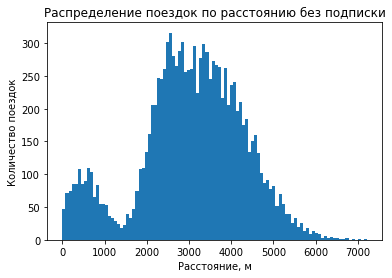

In [19]:
nosub_data['distance'].plot(kind= 'hist', bins= 100);
plt.title('Распределение поездок по расстоянию без подписки')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок');

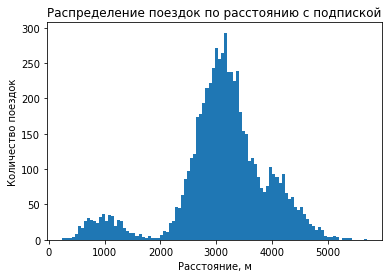

In [20]:
sub_data['distance'].plot(kind= 'hist', bins= 100);
plt.title('Распределение поездок по расстоянию с подпиской')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок');

Распределения примерно схожи.

**Визуализация распределений времени аренды у пользователей без и с подпиской**

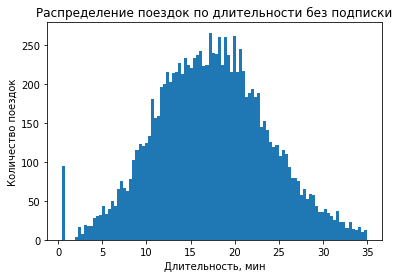

In [21]:
nosub_data['duration'].plot(kind= 'hist', bins= 100);
plt.title('Распределение поездок по длительности без подписки')
plt.xlabel('Длительность, мин')
plt.ylabel('Количество поездок');

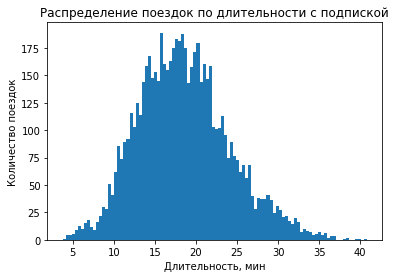

In [22]:
sub_data['duration'].plot(kind= 'hist', bins= 100);
plt.title('Распределение поездок по длительности c подпиской')
plt.xlabel('Длительность, мин')
plt.ylabel('Количество поездок');

Все околонулевые по времени аренды приходятся на пользователей без подписки. 
В остальном распределения примерно одинаковы.

#### Шаг 5. Подсчёт выручки

In [23]:
#создание сводных таблиц по дистанции, количеству поездок 
#и продолжительность за каждый месяц и объединение в датафрейм
pivot_data = (data
              .pivot_table(index= ['user_id', 'month'], 
                           values= 'distance', aggfunc= 'sum')
             )
pivot_data = (pivot_data
              .merge(data.pivot_table(index= ['user_id', 'month'],
                                      values= 'date', aggfunc= 'count'),
                     left_index= True, right_index= True)
              .merge(data.pivot_table(index= ['user_id', 'month'],
                                      values= 'duration', aggfunc= 'sum'),
                     left_index= True, right_index= True)
             )
pivot_data.columns = ['month_dist', 'month_count', 'month_dur']
pivot_data['month_dur'] = np.ceil(pivot_data['month_dur']).astype(int)
pivot_data

month_dist  month_count  month_dur
user_id month                                      
1       1       7027.511294            2         42
        4        754.159807            1          7
        8       6723.470560            2         45
        10      5809.911100            2         32
        11      7003.499363            3         54
...                     ...          ...        ...
1534    6       3409.468534            2         25
        8       7622.453034            2         48
        9       4928.173852            1         23
        11     13350.015305            4         77
        12      2371.711192            1         16

[11331 rows x 3 columns]

In [24]:
#добавление в основной датафрейм столбцов со стоимостью каждой 
#поездки - не учтена месячная плата за подписку
data.loc[data['subscription_type'] == 'free', 'cost_no_fee'] = (
    (np.ceil(data['duration']).astype(int) * data['minute_price'])
+ data['start_ride_price']
)
data.loc[data['subscription_type'] == 'ultra', 'cost_no_fee'] = (
(np.ceil(data['duration']).astype(int) * data['minute_price'])
)
data

,user_id,distance,duration,date,month,year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,cost_no_fee
0,1,4409.919140,25.599769,2021-01-01,1,2021,Кира,22,Тюмень,ultra,6,0,199,156.0
1,1,2617.592153,15.816871,2021-01-18,1,2021,Кира,22,Тюмень,ultra,6,0,199,96.0
2,1,754.159807,6.232113,2021-04-20,4,2021,Кира,22,Тюмень,ultra,6,0,199,42.0
3,1,2694.783254,18.511000,2021-08-11,8,2021,Кира,22,Тюмень,ultra,6,0,199,114.0
4,1,4028.687306,26.265803,2021-08-28,8,2021,Кира,22,Тюмень,ultra,6,0,199,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,2021,Альберт,25,Краснодар,free,8,50,0,210.0
18064,1534,2840.423057,21.409799,2021-11-16,11,2021,Альберт,25,Краснодар,free,8,50,0,226.0
18065,1534,3826.185507,18.435051,2021-11-18,11,2021,Альберт,25,Краснодар,free,8,50,0,202.0
18066,1534,2902.308661,16.674362,2021-11-27,11,2021,Альберт,25,Краснодар,free,8,50,0,186.0


In [25]:
#составление сводной таблицы по оплате по месяцам
cost_no_fee = (data
               .pivot_table(index=['user_id', 'month'],
                            values= 'cost_no_fee',
                            aggfunc= 'sum')
              )
pivot_data = (pivot_data
              .merge(cost_no_fee,
                     left_index= True,
                     right_index= True)
             )

In [26]:
#добавление ежемесячной платы за подписку соответствующим
#пользователям
(pivot_data
 .loc[pivot_data.index.get_level_values(0)
      .isin(sub_data['user_id']), 'cost_no_fee']) = (
pivot_data['cost_no_fee'] + 199 
)

(pivot_data
 .loc[pivot_data.index.get_level_values(0)
      .isin(sub_data['user_id']), 'is_sub']) = True

pivot_data.columns = (['month_dist', 'month_count', 
                      'month_dur','month_cost', 'is_sub']
                     )
#общая сводная таблица
pivot_data

month_dist  month_count  month_dur  month_cost is_sub
user_id month                                                         
1       1       7027.511294            2         42       451.0   True
        4        754.159807            1          7       241.0   True
        8       6723.470560            2         45       475.0   True
        10      5809.911100            2         32       391.0   True
        11      7003.499363            3         54       535.0   True
...                     ...          ...        ...         ...    ...
1534    6       3409.468534            2         25       308.0    NaN
        8       7622.453034            2         48       484.0    NaN
        9       4928.173852            1         23       234.0    NaN
        11     13350.015305            4         77       824.0    NaN
        12      2371.711192            1         16       178.0    NaN

[11331 rows x 5 columns]

## Проверка гипотез

**Гипотеза о разнице времени аренды между пользователями с подпиской и без**
- Нулевая гипотеза: пользователи с подпиской тратят на аренду столько же времени, сколько и пользователи без подписки.
- Альтернативная гипотеза: среднее значение времени аренды пользователей с подпиской больше, чем у пользователей без подписки.


In [27]:
sample_1 = sub_data['duration']
sample_2 = nosub_data['duration']

alpha = 0.001

results = st.ttest_ind(sample_1, sample_2, alternative= 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Гипотеза о расстоянии, проезжаемом пользователями с подпиской**
- Нулевая гипотеза: пользователи с подпиской проезжают за 1 поездку в среднем 3130 м.
- Альтернативная гипотеза: пользователи с подпиской проезжают за 1 поездку в среднем больше 3130 м.

In [28]:
sample_1 = sub_data['distance']

alpha = 0.05

results = st.ttest_1samp(sample_1, 3130, alternative= 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Гипотеза о разнице помесячной выручки между пользователями с подпиской и без**
- Нулевая гипотеза: пользователи с подпиской в среднем за месяц приносят столько же выручки, сколько и без подписки.
- Альтернативная гипотеза: средняя помесяная выручка с пользователя с подпиской выше, чем выручка с пользователя без подписки.

In [29]:
sample_1 = pivot_data.loc[pivot_data['is_sub']==True, 'month_cost']
sample_2 = pivot_data.loc[pivot_data['is_sub'].isna(), 'month_cost']

alpha = 0.05

results = st.ttest_ind(sample_1, sample_2, alternative= 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Тест для проверки изменения количества обращений в поддержку**
- Нулевая гипотеза: среднее количество обращений осталось на том же уровне, что и прежде
- Альтернативная гипотеза: среднее количество обращений в поддержку стало меньше, чем до смены серверов

In [30]:
before = []

after = []

alpha = 0.05 

results = st.ttest_rel(before, after)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве среднего веса посылок')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве среднего веса посылок')

p-значение: nan
Не получилось отвергнуть нулевую гипотезу о равенстве среднего веса посылок


#### Шаг 7. Распределения

Вероятность получить менее 100 подписок после проведения акции равна 0.05,       при общем количестве участников не менее 1171 человек


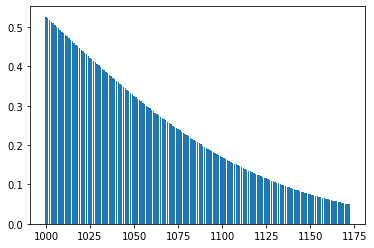

In [31]:
n = 1000 
p = 0.1 
k = 100

left_tail = 1
distr = []

while left_tail > 0.05:
    left_tail = binom.cdf(k, n, p)
    distr.append(left_tail)
    n += 1

plt.bar(range(1000, n), distr);

print(f'Вероятность получить менее 100 подписок после проведения акции равна {round(binom.cdf(k, n-2, p), 2)}, \
      при общем количестве участников не менее {n-2} человек')

Условие применения аппроксимации выполняется


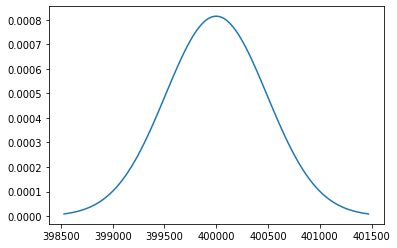

Вероятность того, что уведомление откроют не более 399,5 тыс пользователей из 1 млн: 15.0 %


In [32]:
# параметры биномиального распределения
n = 1000000
p = 0.4

# параметры аппроксимированного нормального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие применения аппроксимации выполняется')
else:
    print('Условие применения аппроксимации не выполняется')


distr = st.norm(mu, sigma)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, st.norm.pdf(x, mu, sigma))
plt.show()

prob = distr.cdf(399500)
print(f'Вероятность того, что уведомление откроют не более 399,5 тыс пользователей из 1 млн: {round(prob, 2)*100} %')

## Общий вывод

Исследовательский анализ данных:
- Примерно равное количество пользователей с подпиской и без, однако пользователей без подписки больше - 54% против 45%.
- Средний возраст пользователей около 25 лет - около 800 человек из выборки, младше 15 лет и старше 35 встречаются единицы.
- Все поездки можно разделить на 2 типа - короткие(600м в среднем) и длинные (3,5км в среднем).
- Средняя длительность поездки в районе 20 минут, имеется небольшое число поездок с длительностью меньше минуты (данные поездки есть только у пользователей без подписки)

Гипотезы: 
- **Разница времени аренды между пользователями с подпиской и без:** среднее значение времени аренды пользователей с подпиской больше, чем у пользователей без подписки.

- **Расстояние, проезжаемое пользователями с подпиской, не превышает оптимальное с точки зрения износа самоката значение:** пользователи с подпиской проезжают за 1 поездку в среднем не более 3130 м.


- **Разнице помесячной выручки между пользователями с подпиской и без:** средняя помесяная выручка с пользователя с подпиской выше, чем выручка с пользователя без подписки.


Рекомендации:
 
- Рекомендации по охвату пользователей промо-акцией: Вероятность получить менее 100 подписок после проведения акции равна 0.05,       при общем количестве участников не менее 1171 человек

- Оценка конверсии push-уведомлений: Вероятность того, что уведомление откроют не более 399,5 тыс пользователей из 1 млн: 15.0 %
 


